In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import math
from datetime import datetime, timedelta

In [2]:
sb.set_style('darkgrid')

# Read data set

In [3]:
df = pd.read_csv('./soc-sign-bitcoinotc.csv', header=None)
df.columns = [ 'source', 'target', 'rating', 'time' ]

In [4]:
df['time'] = pd.to_datetime(df['time'].astype(int), unit='s') 

In [5]:
df = df.sort_values(by='time').reset_index().drop(['index'], axis=1)
df['second'] = df['time'] - df['time'][0]
df['second'] = df['second'].apply(lambda x: math.floor(x.total_seconds()))
df['date'] = df['time'].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# Distribution of rating

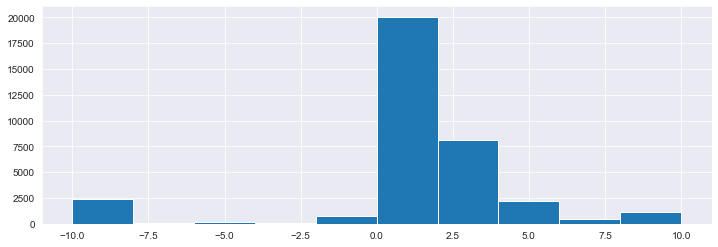

In [6]:
plt.figure(figsize=(12,4))
plt.hist(df['rating'])
plt.show()

# Graph

In [7]:
#G = nx.MultiDiGraph()
records = {}
G = nx.DiGraph()
for line in df.values:
    source = int(line[0])
    target = int(line[1])
    rating = int(line[2])
    G.add_edge(source, target, weight=rating)

    if line[0] not in records:
        records[source] = { 
            'in': 0, 'out': 0, 'total_rating': 0, 'count_rating': 0,
            'max_rating': None, 'min_rating': None
        }

    if line[1] not in records:
        records[target] = { 
            'in': 0, 'out': 0, 'total_rating': 0, 'count_rating': 0,
            'max_rating': None, 'min_rating': None
        }

    records[source]['out'] = records[source]['out'] + 1
    records[target]['in'] = records[target]['in'] + 1
    records[target]['total_rating'] = records[target]['total_rating'] + rating
    records[target]['count_rating'] = records[target]['count_rating'] + 1

    if records[target]['max_rating'] is None:
        records[target]['max_rating'] = rating
    else:
        if rating > records[target]['max_rating']:
            records[target]['max_rating'] = rating

    if records[target]['min_rating'] is None:
        records[target]['min_rating'] = rating
    else:
        if rating < records[target]['min_rating']:
            records[target]['min_rating'] = rating

# Ratings

In [9]:
df_records = pd.DataFrame.from_dict(records, orient='index')
df_records

,in,out,total_rating,count_rating,max_rating,min_rating
6,44,40,61,44,8.0,-10.0
2,41,45,123,41,8.0,-2.0
5,3,3,7,3,4.0,1.0
1,226,215,801,226,10.0,1.0
15,13,15,20,13,4.0,1.0
...,...,...,...,...,...,...
6000,0,1,0,0,NaN,NaN
6002,1,0,1,1,1.0,1.0
6003,1,0,1,1,1.0,1.0
6004,1,0,1,1,1.0,1.0


In [10]:
df_records[['max_rating']].value_counts()

max_rating
 1.0          2748
 2.0           891
 3.0           517
 10.0          451
 5.0           362
 4.0           250
-10.0          180
 8.0           106
-1.0            97
 6.0            71
 7.0            61
-2.0            55
 9.0            40
-5.0            16
-3.0             4
-8.0             4
-9.0             3
-4.0             1
-7.0             1
dtype: int64

## Distribution of ratings

In [11]:
df_records['average_rating'] = df_records['total_rating'] / df_records['count_rating']

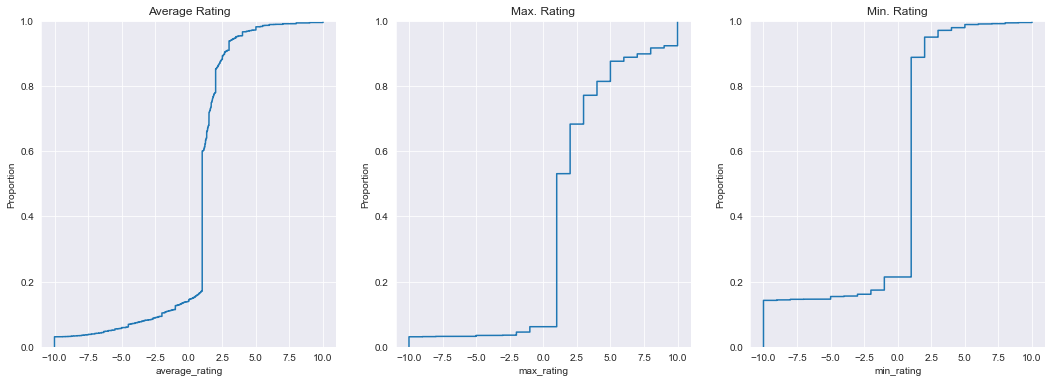

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sb.ecdfplot(data=df_records, x='average_rating', complementary=False, ax=ax[0]).set_title('Average Rating')
sb.ecdfplot(data=df_records, x='max_rating', complementary=False, ax=ax[1]).set_title('Max. Rating')
sb.ecdfplot(data=df_records, x='min_rating', complementary=False, ax=ax[2]).set_title('Min. Rating')
plt.show()

# Degree Distribution


## Degree centrality

In [13]:
df_degree = pd.DataFrame(nx.algorithms.degree_centrality(G).items(), columns=['Node','Degree']).set_index(['Node'])
#df_degree = df_degree.set_index(['Node'])
df_indegree = pd.DataFrame(nx.algorithms.in_degree_centrality(G).items(), columns=['Node','In-degree']).set_index(['Node'])
df_outdegree = pd.DataFrame(nx.algorithms.out_degree_centrality(G).items(), columns=['Node','Out-degree']).set_index(['Node'])
# df_degrees = df_degree.join(df_indegree, how='inner', on=['Node'], rsuffix='_in', sort=True).join(df_outdegree, how='inner', on=['Node'], rsuffix='_out', sort=True)
df_degrees = df_degree.join(df_indegree, how='outer').join(df_outdegree, how='outer').sort_index()
df_degrees

,Degree,In-degree,Out-degree
Node,,,
1,0.075000,0.038435,0.036565
2,0.014626,0.006973,0.007653
3,0.003571,0.003571,0.000000
4,0.019898,0.009184,0.010714
5,0.001020,0.000510,0.000510
...,...,...,...
6000,0.000170,0.000000,0.000170
6002,0.000170,0.000170,0.000000
6003,0.000170,0.000170,0.000000


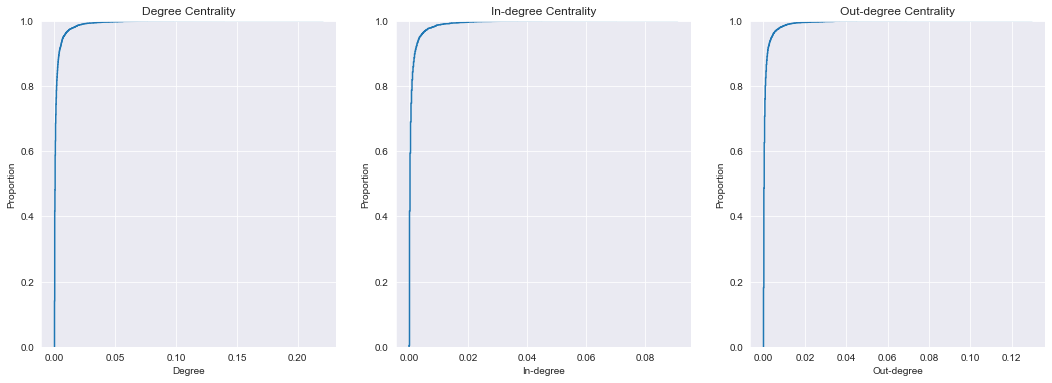

In [14]:
#sb.histplot(data=df_degree, x='Degree', stat='probability', binwidth=0.001, cumulative=True)
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sb.ecdfplot(data=df_degrees, x='Degree', complementary=False, ax=ax[0]).set_title('Degree Centrality')
sb.ecdfplot(data=df_degrees, x='In-degree', complementary=False, ax=ax[1]).set_title('In-degree Centrality')
sb.ecdfplot(data=df_degrees, x='Out-degree', complementary=False, ax=ax[2]).set_title('Out-degree Centrality')
plt.show()

# Clustering coefficient

In [15]:
clustering_coefficients = pd.DataFrame(nx.algorithms.cluster.clustering(G).items(), columns=['Node','Clustering coe.']).set_index(['Node'])
clustering_coefficients

,Clustering coe.
Node,
6,0.126121
2,0.102292
5,1.000000
1,0.045780
15,0.065395
...,...
6000,0.000000
6002,0.000000
6003,0.000000


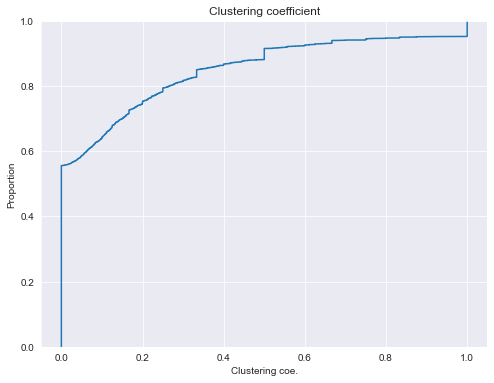

In [26]:
plt.figure(figsize=(8,6))
sb.ecdfplot(data=clustering_coefficients, x='Clustering coe.', complementary=False).set_title('Clustering coefficient')
plt.show()

# Closeness Centrality

In [17]:
closeness = pd.DataFrame(nx.algorithms.centrality.closeness_centrality(G).items(), columns=['Node','Closeness']).set_index(['Node'])
closeness

,Closeness
Node,
6,0.296063
2,0.265506
5,0.242396
1,0.330994
15,0.251884
...,...
6000,0.000000
6002,0.000170
6003,0.173228


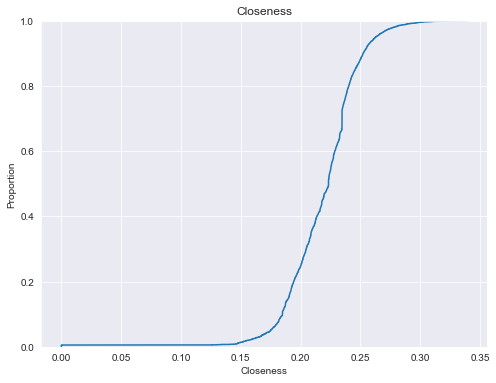

In [19]:
plt.figure(figsize=(8,6))
sb.ecdfplot(data=closeness, x='Closeness', complementary=False).set_title('Closeness')
plt.show()

# Betweenness

In [20]:
betweenness = nx.algorithms.centrality.betweenness_centrality(G)

In [22]:
betweenness_df = pd.DataFrame(betweenness.items(), columns=['Node','Betweenness']).set_index(['Node'])

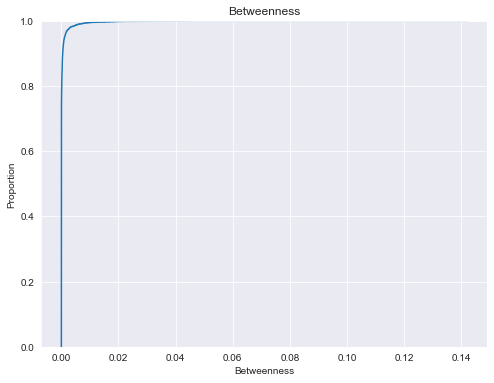

In [23]:
plt.figure(figsize=(8,6))
sb.ecdfplot(data=betweenness_df, x='Betweenness', complementary=False).set_title('Betweenness')
plt.show()

# Graph Drawing

In [24]:
G = nx.MultiDiGraph()
for line in df[(df['time'] >= datetime(2010,11,8)) & (df['time'] < datetime(2010,11,30))].values:
    G.add_edge(line[0], line[1], weight=int(line[2]))

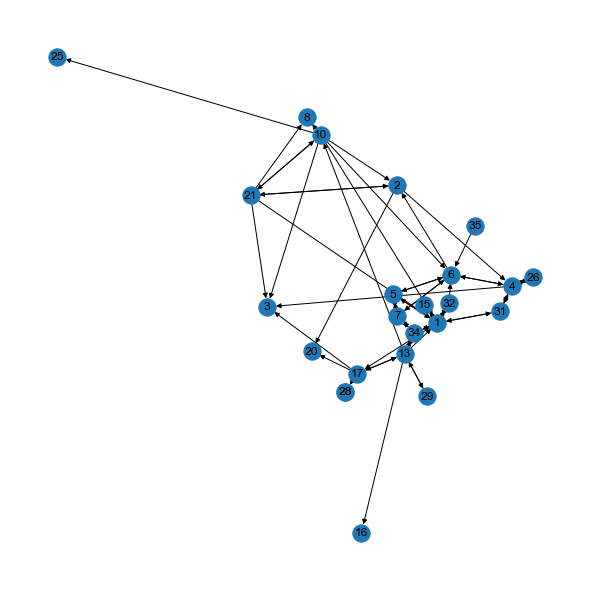

In [25]:
plt.figure(figsize=(8,8))
nx.draw_kamada_kawai(G, with_labels=True)